# Creating Ridge Plots from FlowJo exported Flow Cytometry Histograms

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
%matplotlib inline

In [5]:
datfile = "flow.csv"
data = pd.read_csv(datfile).set_index("bins")
data.describe()

,parental,deltaP,deltaE,Psgl,Lsel,LFA,VLA,Cd44,deltaP_Hi,deltaP_medHi,deltaP_med,deltaP_medLo,deltaP_lo
count,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000
mean,2.246338,2.202393,2.176270,2.249512,2.196289,2.075439,2.194092,2.134766,1.621582,1.797119,1.955566,2.089844,2.165771
std,11.239065,3.157379,3.456082,4.102681,3.609923,3.213893,3.234683,2.967616,2.746846,2.945181,3.084560,3.127683,3.335473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,2.000000,3.000000,3.000000,4.000000,4.000000
max,113.000000,15.000000,17.000000,24.000000,26.000000,19.000000,17.000000,18.000000,16.000000,18.000000,17.000000,17.000000,17.000000


In [16]:
def ridge_plot(df):
    sns.set_style("white")
    # List of separable colors
    colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
          '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
    
    # FlowJo seems to give populations as columns and bins is fluoresence intensities corrected and binned?
    populations = [col for col in df.columns]
    rows = len(populations)
    
    #print(f"Generating {rows} rows in figure...")
    # Create figure rows based on number of populations
    fig,axs = plt.subplots(rows,1,figsize=(20,10))

    # NOTE: this could probably be done with a groupby
    # Need to iterate over populations
    for i,pop in enumerate(populations):
        #print(i,pop)
        
        # White line for density to make boundaries pop more
        plot = df[pop].plot.kde(ax=axs[i],color="white", linewidth=2)

        # Fill under graph with different color
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x,y,color=colors[i])

        # Set the background transparent
        axs[i].patch.set_alpha(0)

        # Remove y ticks and y labels
        axs[i].set_yticklabels([])
        axs[i].set_ylabel("")
        # Remove x ticks except for bottom subplot
        if i != rows-1:
            axs[i].set_xticklabels([])

        # Remove all spines    
        spines = ["left","top","right","bottom"]
        for spine in spines:
            axs[i].spines[spine].set_visible(False)
        
        # TODO: I've only been able to adjust this position hardcoded, find solution
        # New Y labels
        axs[i].text(-2,0,pop,fontweight="bold",fontsize=24,ha="right")
        
        xmin,xmax = -10,15
        #xmin = min(df[pop])
        #xmax = max(df[pop])
        #print(f"Min :{xmin} Max :{xmax}")
        axs[i].set_xlim(xmin,xmax)
        #axs[i].xticks(range(min(valueX), max(valueX)+1))
    # Overlap subplots
    plt.subplots_adjust(hspace=-0.5)
    plt.show()

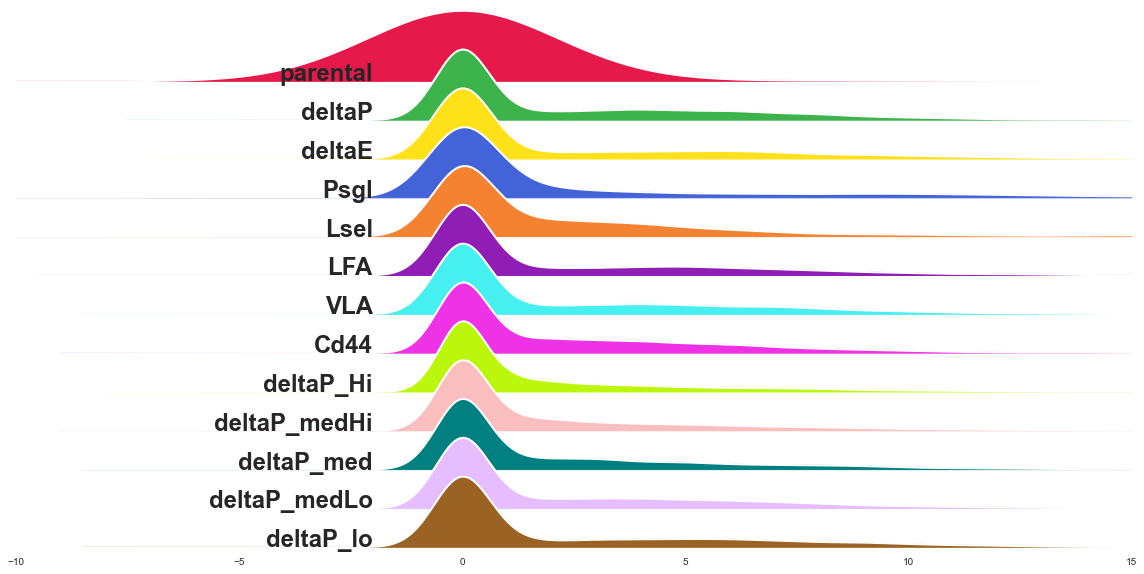

In [17]:
ridge_plot(data)